In [265]:
import matplotlib.pyplot as plt
%matplotlib qt
import numpy as np

In [58]:
# def rand_submatrix_row(A, d):
#     assert len(A[0]) == len(A)
#     indices = np.random.choice(np.arange(len(A)), d)
# #     print(indices)
#     return A[indices]

# def rand_submatrix_col(A, d):
#     assert len(A[0]) == len(A)
#     indices = np.random.choice(np.arange(len(A)), d)
# #     print(indices)
#     return A[:, indices]

def sample_submatrix_row(A, indices):
    return A[:, indices]

def sample_submatrix_col(B, indices):
    return B[indices]

def gen_opt_weights(A, B):
    assert A.shape == B.shape
    w = []
    for i in range(len(A)):
        Af = np.linalg.norm(A[:, i])
        Bf = np.linalg.norm(B[i])
        w.append(Af*Bf)
    w = np.array(w)
    return w/(np.sum(w))

def sketched_mat_mul_w(A, B, d, w):
    indices = np.random.choice(np.arange(len(A)), d, p = w)
    return sample_submatrix_row(A, indices)@np.diag(np.reciprocal(d*w[indices]))@sample_submatrix_col(B, indices)    

def sketched_mat_mul(A, B, d):
    w = gen_opt_weights(A, B)
    indices = np.random.choice(np.arange(len(A)), d, p = w)
    return sample_submatrix_row(A, indices)@np.diag(np.reciprocal(d*w[indices]))@sample_submatrix_col(B, indices)

In [59]:
def naive_mat_mul(A, B):
    C = np.zeros((A.shape[0], B.shape[1]))
    for i in range(0, A.shape[0]):
        for j in range(0, B.shape[1]):
            C[i][j] = np.dot(A[i, :], B[:, j])
    return C

A = np.arange(0, 9).reshape(3, 3)
B = np.arange(10, 19).reshape(3, 3)

In [200]:
import time
import math

def do_sims(Ks, gen_method):
    theory_errs = []
    opt_errs = []
    errs = []
    C_times = []
    D_times = []
    A_frob_norms= []
    B_frob_norms = []
    prod_frob_norms = []

    theory_errs = []

    for k in Ks:
#         print(k)

        A = gen_method(k)
        B = gen_method(k)

        d = int(math.log(k)/0.01)
#         d = int()
        opt_indices = np.random.choice(np.arange(len(A)), d, p = gen_opt_weights(A, B))
        indices = np.random.choice(np.arange(len(A)), d)

        A_ = sample_submatrix_row(A, indices)
        B_ = sample_submatrix_col(B, indices)
        start = time.process_time()
        C1 = (A_@B_)*(k/d)
        C_time = time.process_time() - start


        C2 = sketched_mat_mul(A, B, d)

        
        start = time.process_time()
        D = A@B
        D_time = time.process_time() - start
        C_times.append(C_time)
        D_times.append(D_time)

        A_frob_norm = np.linalg.norm(A)
        B_frob_norm = np.linalg.norm(B)
        D_frob_norm = np.linalg.norm(D)

        theory_errs.append((np.sum([np.linalg.norm(A[:, i])*np.linalg.norm(B[i]) for i in range(0, k)])**2/d)) #Check rows/columns

        prod_frob_norms.append(D_frob_norm**2)
        A_frob_norms.append(A_frob_norm)
        B_frob_norms.append(B_frob_norm)
        errs.append(np.linalg.norm(C1 - D)**2)
        opt_errs.append(np.linalg.norm(C2 - D)**2)
        
    return {"opt_errs": opt_errs, "errs": errs, "product norms": prod_frob_norms, "A norms": A_frob_norms, "B norms": B_frob_norms, "theory": theory_errs, "C times": C_times, "D times": D_times}

In [256]:
def gaussian_matrix(k):
    return np.random.normal(0, 1/(k**2), k**2).reshape(k, k)

def arange_matrix(k):
    A = np.arange(0, k**2).reshape(k, k)
    return A/np.linalg.norm(A)

from scipy.stats import special_ortho_group
def scale_and_rotate(k):
    A = special_ortho_group.rvs(k)
    return A

import random
from itertools import combinations

def random_laplacian(k):
    A = np.zeros((k, k))
    p = 1
    for i, j in combinations(list(range(k)), 2):
        if random.random() < p:
            A[i, j] = -1
            A[j, i] = -1
    np.fill_diagonal(A, np.sum(np.abs(A), axis = 1))
    return A

def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

def ring_graph_laplacian(k):
    A = tridiag(-1*np.ones(k - 1), 2*np.ones(k), -1*np.ones(k-1))
    A[-1][0] = -1
    A[0][-1] = -1
    return A

def ones(k):
    return np.ones(k**2).reshape(k, k)

def left_heavy(k):
    return np.array([np.ones(k)*(p + 1) for p in range(k)]).T

In [202]:
Ks = np.array([k for k in range(50, 3000, 100)])
gaussian_sims = do_sims(Ks, gaussian_matrix)

In [203]:
arange_sims = do_sims(Ks, arange_matrix)

In [257]:
scaled_sims = do_sims(Ks, scale_and_rotate)

KeyboardInterrupt: 

In [205]:
ring_graph_sims = do_sims(Ks, ring_graph_laplacian)

In [206]:
laplacian_sims = do_sims(Ks, random_laplacian)

In [207]:
ones_sims = do_sims(Ks, ones)

In [208]:
left_heavy_sims = do_sims(Ks, left_heavy)


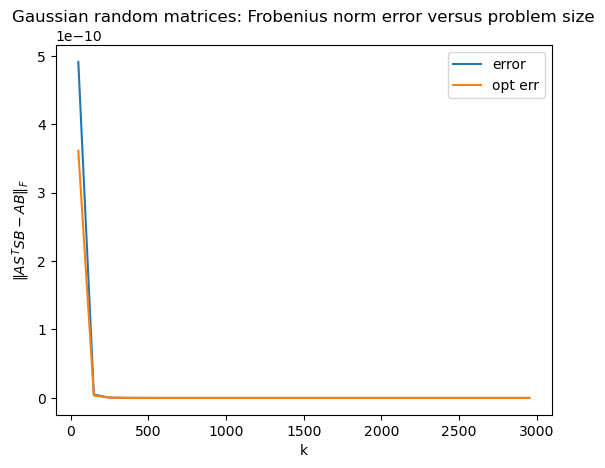

In [210]:
plt.title("Gaussian random matrices: Frobenius norm error versus problem size")
plt.ylabel("$\|AS^TSB - AB\|_F$")
plt.xlabel("k")
plt.plot(Ks, gaussian_sims["errs"], label = "error")
plt.plot(Ks, gaussian_sims["opt_errs"], label = "opt err")
# plt.plot(Ks, gaussian_sims["theory"], label = "theory")
# plt.plot(Ks, gaussian_sims["product norms"], label = "trivial")


plt.legend()

# Note, numpy optimizations for mat mul is changing the amount of time this takes. Should do these sims with naive mat mul algorithm

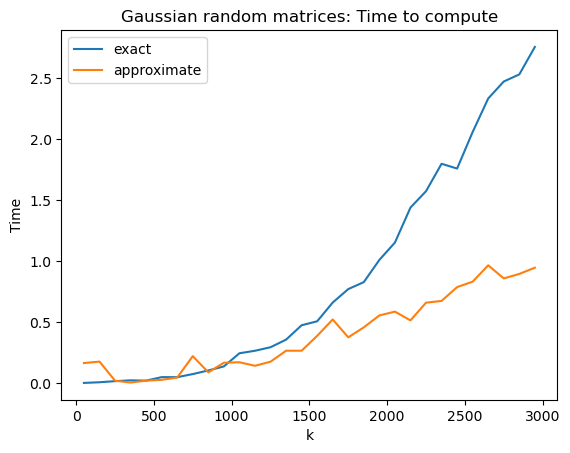

In [179]:
plt.title("Gaussian random matrices: Time to compute")
plt.ylabel("Time")
plt.xlabel("k")
plt.plot(Ks, gaussian_sims["D times"], label = "exact")
plt.plot(Ks, gaussian_sims["C times"], label = "approximate")

# plt.plot(Ks, [k**2*math.log(k) for k in Ks])
plt.legend()

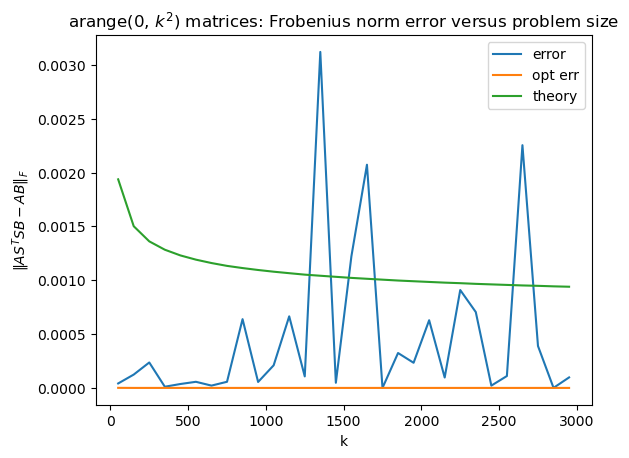

In [214]:
plt.title("arange(0, $k^2$) matrices: Frobenius norm error versus problem size")
plt.ylabel("$\|AS^TSB - AB\|_F$")
plt.xlabel("k")
plt.plot(Ks, arange_sims["errs"], label = "error")
plt.plot(Ks, arange_sims["opt_errs"], label = "opt err")
plt.plot(Ks, arange_sims["theory"], label = "theory")

# plt.plot(Ks, arange_sims["product norms"], label = "trivial")


plt.legend()

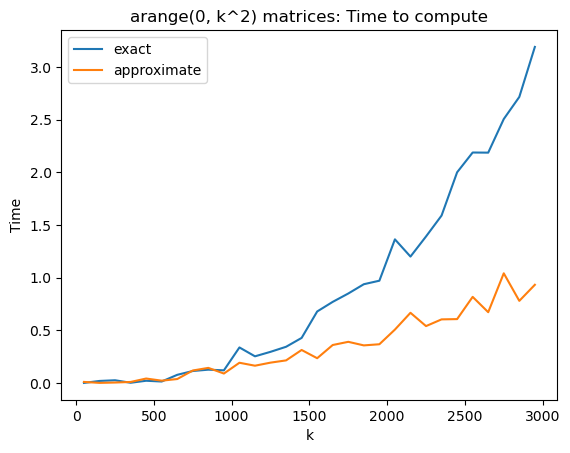

In [215]:
plt.title("arange(0, k^2) matrices: Time to compute")
plt.ylabel("Time")
plt.xlabel("k")
plt.plot(Ks, arange_sims["D times"], label = "exact")
plt.plot(Ks, arange_sims["C times"], label = "approximate")


# plt.plot(Ks, [k**2*math.log(k) for k in Ks])
plt.legend()

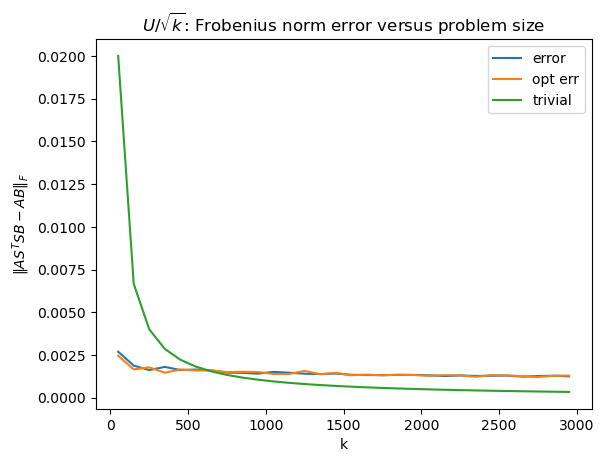

In [239]:
plt.title("$U/\sqrt{k}$: Frobenius norm error versus problem size")
plt.ylabel("$\|AS^TSB - AB\|_F$")
plt.xlabel("k")
plt.plot(Ks, scaled_sims["errs"], label = "error")
plt.plot(Ks, scaled_sims["opt_errs"], label = "opt err")
# plt.plot(Ks, scaled_sims["theory"], label = "theory")
plt.plot(Ks, scaled_sims["product norms"], label = "trivial")
# plt.plot(Ks, scaled_sims["product norms"])
plt.legend()

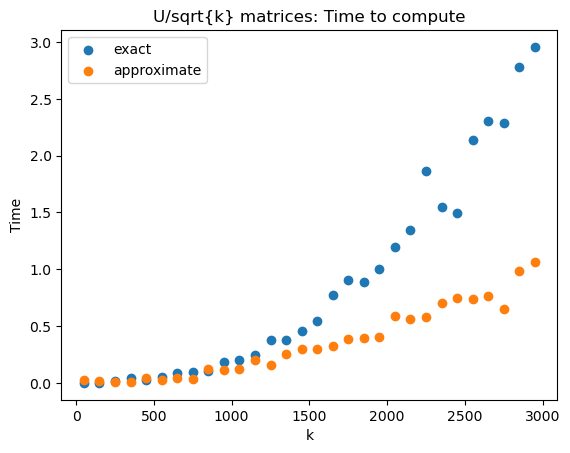

In [184]:
plt.title("U/sqrt{k} matrices: Time to compute")
plt.ylabel("Time")
plt.xlabel("k")
plt.scatter(Ks, scaled_sims["D times"], label = "exact")
plt.scatter(Ks, scaled_sims["C times"], label = "approximate")
# plt.plot(Ks, [k**2*math.log(k) for k in Ks])
plt.legend()

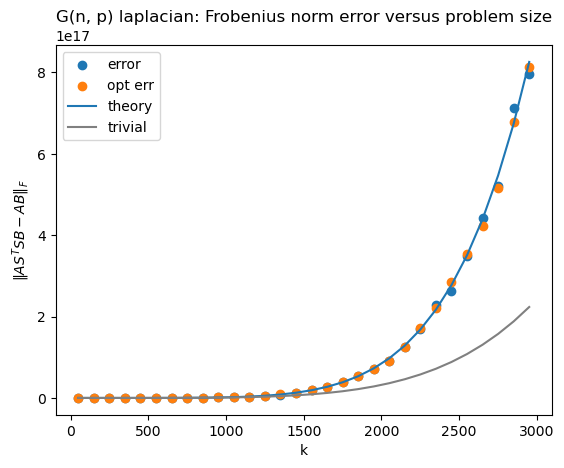

In [217]:
plt.title("G(n, p) laplacian: Frobenius norm error versus problem size")
plt.ylabel("$\|AS^TSB - AB\|_F$")
plt.xlabel("k")
plt.scatter(Ks, laplacian_sims["errs"], label = "error")
plt.scatter(Ks, laplacian_sims["opt_errs"], label = "opt err")
plt.plot(Ks, laplacian_sims["theory"], label = "theory")
plt.plot(Ks, laplacian_sims["product norms"], label = "trivial", color = "gray")
# plt.plot(Ks, scaled_sims["product norms"])
plt.legend()

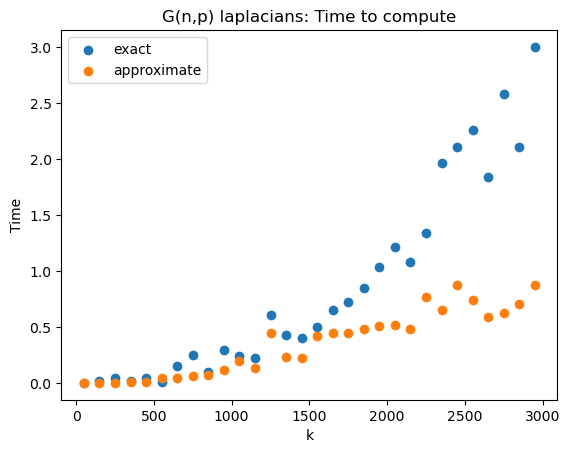

In [218]:
plt.title("G(n,p) laplacians: Time to compute")
plt.ylabel("Time")
plt.xlabel("k")
plt.scatter(Ks, laplacian_sims["D times"], label = "exact")
plt.scatter(Ks, laplacian_sims["C times"], label = "approximate")
# plt.plot(Ks, [k**2*math.log(k) for k in Ks])
plt.legend()

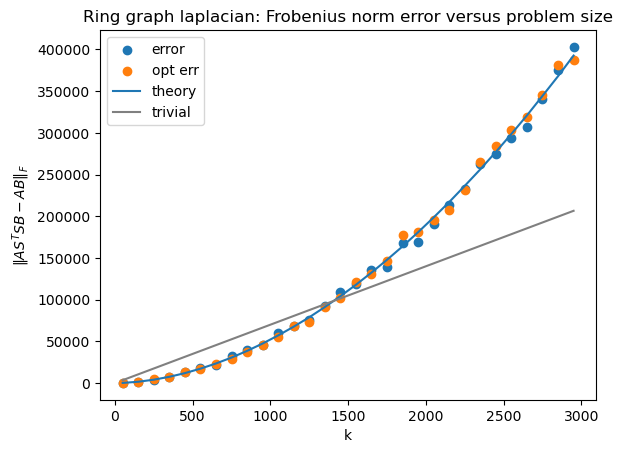

In [220]:
plt.title("Ring graph laplacian: Frobenius norm error versus problem size")
plt.ylabel("$\|AS^TSB - AB\|_F$")
plt.xlabel("k")
plt.scatter(Ks, ring_graph_sims["errs"], label = "error")
plt.scatter(Ks, ring_graph_sims["opt_errs"], label = "opt err")
plt.plot(Ks, ring_graph_sims["theory"], label = "theory")
plt.plot(Ks, ring_graph_sims["product norms"], label = "trivial", color = "gray")
# plt.plot(Ks, scaled_sims["product norms"])
plt.legend()

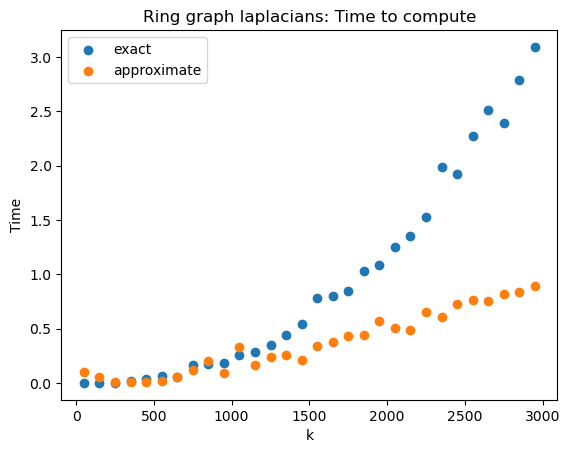

In [188]:
plt.title("Ring graph laplacians: Time to compute")
plt.ylabel("Time")
plt.xlabel("k")
plt.scatter(Ks, ring_graph_sims["D times"], label = "exact")
plt.scatter(Ks, ring_graph_sims["C times"], label = "approximate")
# plt.plot(Ks, [k**2*math.log(k) for k in Ks])
plt.legend()

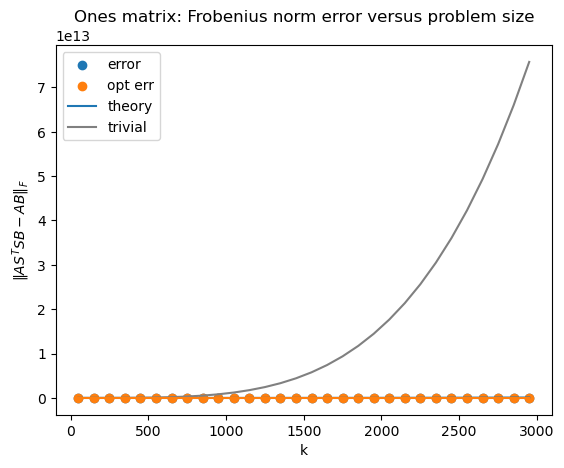

In [223]:
plt.title("Ones matrix: Frobenius norm error versus problem size")
plt.ylabel("$\|AS^TSB - AB\|_F$")
plt.xlabel("k")
plt.scatter(Ks, ones_sims["errs"], label = "error")
plt.scatter(Ks, ones_sims["opt_errs"], label = "opt err")
plt.plot(Ks, ones_sims["theory"], label = "theory")
plt.plot(Ks, ones_sims["product norms"], label = "trivial", color = "gray")
plt.plot(Ks, scaled_sims["product norms"])
plt.legend()

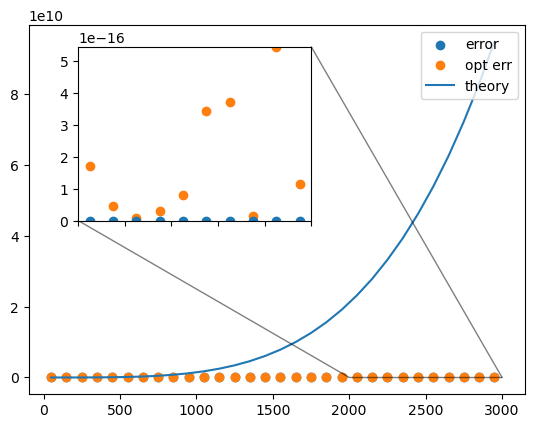

In [237]:
fig, ax = plt.subplots()

# ax.ylabel("$\|AS^TSB - AB\|_F$")
# ax.xlabel("k")
ax.scatter(Ks, ones_sims["errs"], label = "error")
ax.scatter(Ks, ones_sims["opt_errs"], label = "opt err", color = "tab:orange")
ax.plot(Ks, ones_sims["theory"], label = "theory")

W = np.array(ones_sims["errs"])
Z = np.array(ones_sims["opt_errs"])
x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9  # subregion of the original image
axins = ax.inset_axes(
    [0.1, 0.47, 0.47, 0.47],
    xlim=([2000, 3000]), ylim=(0, np.max(Z)), xticklabels = [])
axins.scatter(Ks, ones_sims["opt_errs"], label = "opt err", color = "tab:orange")
axins.scatter(Ks, ones_sims["errs"], label = "err", color = "tab:blue")



ax.indicate_inset_zoom(axins, edgecolor="black")

plt.legend(loc = "upper right")
plt.show()




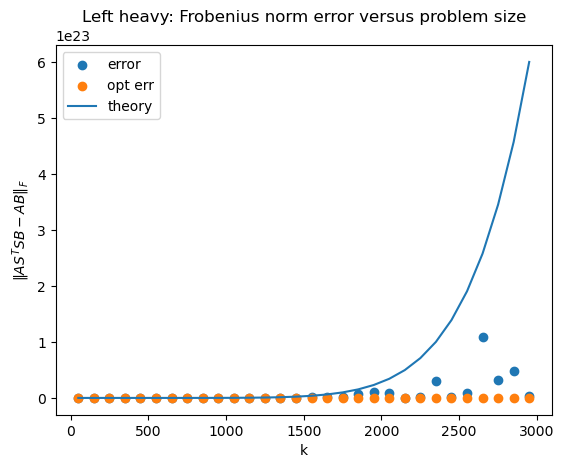

In [224]:
plt.title("Left heavy: Frobenius norm error versus problem size")
plt.ylabel("$\|AS^TSB - AB\|_F$")
plt.xlabel("k")
plt.scatter(Ks, left_heavy_sims["errs"], label = "error")
plt.scatter(Ks, left_heavy_sims["opt_errs"], label = "opt err")
plt.plot(Ks, left_heavy_sims["theory"], label = "theory")

# plt.plot(Ks, ring_graph_sims["product norms"], label = "trivial", color = "gray")
# plt.plot(Ks, scaled_sims["product norms"])
plt.legend()

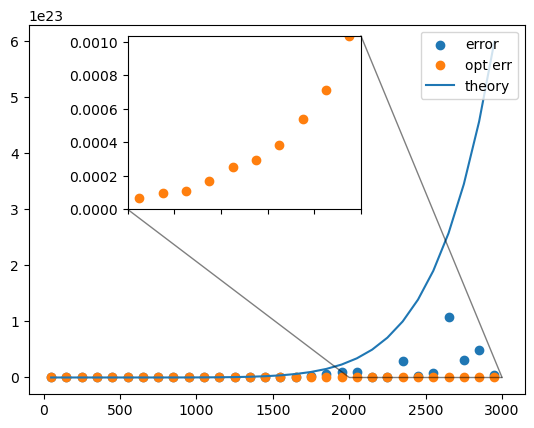

In [238]:
fig, ax = plt.subplots()

# ax.ylabel("$\|AS^TSB - AB\|_F$")
# ax.xlabel("k")
ax.scatter(Ks, left_heavy_sims["errs"], label = "error")
ax.scatter(Ks, left_heavy_sims["opt_errs"], label = "opt err", color = "tab:orange")
ax.plot(Ks, left_heavy_sims["theory"], label = "theory")


Z = np.array(left_heavy_sims["opt_errs"])
x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9  # subregion of the original image
axins = ax.inset_axes(
    [0.2, 0.5, 0.47, 0.47],
    xlim=([2000, 3000]), ylim=(np.min(Z), np.max(Z)), xticklabels = [])
axins.scatter(Ks, left_heavy_sims["opt_errs"], label = "opt err", color = "tab:orange")

ax.indicate_inset_zoom(axins, edgecolor="black")

plt.legend(loc = "upper right")
plt.show()



In [277]:
fig, axs = plt.subplots(2, 3)
sims = [gaussian_sims, arange_sims, scaled_sims, ring_graph_sims, ones_sims, left_heavy_sims]

ax0 = axs[0, 0]
ax1 = axs[0, 1]
ax2 = axs[0, 2]
ax3 = axs[1,0]
ax4 = axs[1, 1]
ax5 = axs[1, 2]


fig.suptitle("$\|AS^TSB - AB\|_F^2$ versus $k$")

ax0.title.set_text("Gaussian")
ax0.scatter(Ks, gaussian_sims["errs"], label = "error")
ax0.scatter(Ks, gaussian_sims["opt_errs"], label = "opt err")
ax0.plot(Ks, gaussian_sims["theory"], label = "theory", color = "green")

ax1.title.set_text("Arange(0, k**2)")
ax1.scatter(Ks, arange_sims["errs"], label = "error")
ax1.scatter(Ks, arange_sims["opt_errs"], label = "opt err")
ax1.plot(Ks, arange_sims["theory"], label = "theory", color = "green")

ax2.title.set_text("Random orthgonal matrix")
ax2.scatter(Ks, scaled_sims["errs"], label = "error")
ax2.scatter(Ks, scaled_sims["opt_errs"], label = "opt err")
ax2.plot(Ks, scaled_sims["theory"], label = "theory", color = "green")

ax4.title.set_text("Ones matrix")
ax4.scatter(Ks, ones_sims["errs"], label = "error")
ax4.scatter(Ks, ones_sims["opt_errs"], label = "opt err", color = "tab:orange")
ax4.plot(Ks, ones_sims["theory"], label = "theory", color = "green")

W = np.array(ones_sims["errs"])
Z = np.array(ones_sims["opt_errs"])
x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9  # subregion of the original image
axins4 = ax4.inset_axes(
    [0.1, 0.47, 0.47, 0.47],
    xlim=([2000, 3000]), ylim=(0, np.max(Z)), xticklabels = [])
# axins4.ticklabel_format( style='sci')
axins4.scatter(Ks, ones_sims["opt_errs"], label = "opt err", color = "tab:orange")
axins4.scatter(Ks, ones_sims["errs"], label = "err", color = "tab:blue")

# ax4.indicate_inset_zoom(axins, edgecolor="black")



ax.indicate_inset_zoom(axins, edgecolor="black")

ax5.title.set_text("Ring graph Laplacian")
ax5.scatter(Ks, ring_graph_sims["errs"], label = "error")
ax5.scatter(Ks, ring_graph_sims["opt_errs"], label = "opt err")
ax5.plot(Ks, ring_graph_sims["theory"], label = "theory", color = "green")

ax3.title.set_text("Left heavy matrix")
ax3.scatter(Ks, left_heavy_sims["errs"], label = "error")
ax3.scatter(Ks, left_heavy_sims["opt_errs"], label = "opt err", color = "tab:orange")
ax3.plot(Ks, left_heavy_sims["theory"], label = "theory", color = "green")

W = np.array(left_heavy_sims["errs"])
Z = np.array(left_heavy_sims["opt_errs"])
x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9  # subregion of the original image
axins3 = ax3.inset_axes(
    [0.2, 0.47, 0.47, 0.47],
    xlim=([2000, 3000]), ylim=(0, np.max(Z)), xticklabels = [])
axins3.scatter(Ks, left_heavy_sims["opt_errs"], label = "opt err", color = "tab:orange")
axins3.scatter(Ks, left_heavy_sims["errs"], label = "err", color = "tab:blue")

# ax3.indicate_inset_zoom(axins, edgecolor="black")



                   
fig.legend(["error", "opt err", "theory"])

In [250]:
axs

array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)